## Amacımız bir başvuru sahibinin krediyi geri ödeyip ödeyemeyeceğini 
## tahmin etmek için geçmiş kredi başvuru verilerini kullanmaktır.
### -------------------------------
## tahmin edilecek kolon 'TARGET' kolonudur. Bu kolon application_train tablosunda bulunur.
## TARGET 0 veya 1 değerini alır. 0: geri ödendiği 1: geri ödenmediği anlamına gelir
## bu değer train datasında bilindiği için 0 veya 1 dir.
## 
## application_test tablosunda ilgili kısmı tahmin etmeye çalışacağız.
### -------------------------------
## Kullandığım dataset kaggle da bir yarışmada sunulan Home Credit Group 
## isimli finas şirketinin verileridir.
### -------------------------------
## İkisi application(test ve train) olmak üzere toplam 8 adet tablo bulunmaktadır.
## ayrıca tüm tablolardaki kolonların bilgisini kısmen açıklayan 'HomeCredit_columns_description' isimli
## bir adet tablo daha vardır
## asıl üstünde çalışılacak tablo 'application_' tablosudur. Diğer tabloları yeri geldikçe anlatmaya çalışacağım
## Kredilerin kimlikleri ("SK_ID_PREV" ve "SK_ID_CURR") birincil anahtarlarıdır, 
## tablolar bu anahtarlarla birbirine bağlanır.
### -------------------------------
## verinin analizi ve finansal bilgi gerektiği yerlerde burdaki çözümden yararlandım
<a>https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/code</a>

In [436]:
#garbage collection kaynak yönetimi için kullanılacak
#bellek yönetimi işleminde kullanılmaktadır
import gc
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings('ignore')

In [437]:
# başvuruların olduğu application datasını dataframe e dönüştürelim 
app_train = pd.read_csv(Path("data/application_train.csv"))
app_test = pd.read_csv(Path("data/application_test.csv"))
print('Training data shape: {}, Testing data shape: {}'.format( app_train.shape,app_test.shape))

Training data shape: (307511, 122), Testing data shape: (48744, 121)


In [438]:
df = app_train
df = df.append(app_test)
# çok fazla kolon bulunduğu için tabloda tamamının görünmesi için alttaki bu satır eklenir
pd.options.display.max_columns = df.shape[1]
df.describe(include = 'all')

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.000000,3.562550e+05,3.559770e+05,3.562550e+05,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,176307.000000,176307.000000,176307.000000,148671.000000,148671.000000,148671.000000,356255.000000,356253.000000,356255,107895.000000,107895.000000,107895.000000,356255.000000,356255.000000,356255.000000,356254.000000,356255.000000,355205.000000,355205.000000,167175.000000,167175.000000,167175.000000,188291,177848.000000,177848.000000,177848.000000,162345.000000,3.555870e+05,286622.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.00000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255,356255,356255.000000,356255.000000,179914.000000,179914.000000,179914.000000,115147.000000,115147.000000,115147.000000,113163,356255.000000,178339,145411.000000,145411.000000,145411.000000,356255.000000,356255.000000,113276.000000,113276.000000,113276.000000,178353.000000,178353.000000,178353.000000,356255,356255,356255,356255,356255,354052,109394.000000,109394.000000,109394.000000,160489.000000,160489.000000,160489.000000,355205.000000,355205.000000,244259,356255,121014.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,307511.000000,185200.000000,176021,356255,183392.000000,183392.000000,183392.000000,119949.000000,119949.000000,119949.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

###DAYS_EMPLOYED kolonunun max değerinin çok büyük olduğu görünüyor. Bu aykırı değer ciddi hatalara
### sebep olabilir.


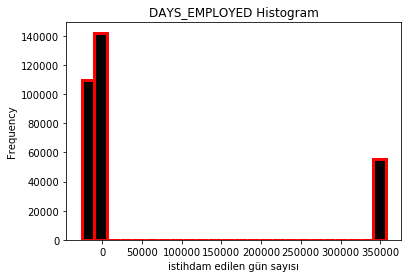

In [439]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'DAYS_EMPLOYED Histogram', bins=24, align='left', color='black', edgecolor='red', linewidth=3);
plt.xlabel('istihdam edilen gün sayısı');

In [440]:
(app_train['DAYS_EMPLOYED'].max())/365

1000.6657534246575

### üstedede görüldüğü gibi DAYS_EMPLOYED kolonundaki max data 365243 gibi çok gerçek dışı bir sayıdır.
### 365 e böldüm 1000 yıl gibi bir değer geldi. Bu sebeple bu kolondaki böyle büyük değerlere Nan değeri atayacağım

In [441]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

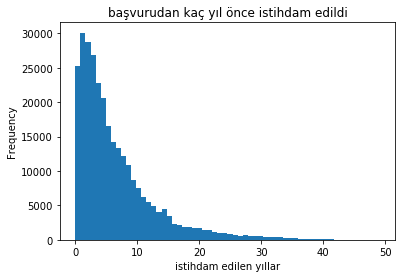

In [442]:
(df['DAYS_EMPLOYED']/(-365)).plot.hist(title='başvurudan kaç yıl önce istihdam edildi',bins=60)
plt.xlabel('istihdam edilen yıllar');
        

In [443]:
# object türü değişkenlerin içerisinde bulunan uniq sayılarına baktık
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

# CODE_GENDER da bi tuhaflık var normalde cinsiyet male ve fermale olarak 2 çeşittir burda 3 çıktı.
#Biraz daha içeriğine bakalım

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [444]:
app_train['CODE_GENDER'].unique() 


array(['M', 'F', 'XNA'], dtype=object)

### Görüldüğü gibi M ve F dışında XNA isimli bir veri var bunu silmemiz lazım

In [445]:
print (df['CODE_GENDER'].value_counts())
print ('\nboyut:  {}'.format(df.shape))
df = df[df['CODE_GENDER'] != 'XNA']
print ('boyut: {}'.format(df.shape))

# 4 adet xna içeren satır silindi

F      235126
M      121125
XNA         4
Name: CODE_GENDER, dtype: int64

boyut:  (356255, 122)
boyut: (356251, 122)


## Label Encoder ve One Hot Encoding
#### Bu kısım da kategorik verileri modele uygun hale getireceğiz
#### label encoder ile text olan kategorik veriler 0, 1, 2 gibi etiketlenecek
#### modelin hızlı çalışması için gerekli bir dönüşüm
#### ayrıca one hot encoding ise makine öğrenmesi algoritmalarının etkin çalışması için grekli
#### bu dönüşümde 0, 1 gibi boolean değerlerle kategorik değerler etiketlenir.
#### ayrıca bu dönüşümler lightGbm deki bundle işlemini etkin kullanmak için de gereklidir

In [446]:
####  Label Encoder  ####
label_encoder = LabelEncoder()
label_encoder_count = 0
# bütün kolonları tarayacağız
for col in df:
    if df[col].dtype == 'object':
        # 2 veya daha az benzersiz kategori varsa
        if len(list(df[col].unique())) <= 2:
            label_encoder.fit(df[col])
            df[col] = label_encoder.transform(df[col])
            label_encoder_count += 1
print ('{} tane değişken label encoder la etiketlendi'.format(label_encoder_count))


####  One Hot Encoding  ####
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
df = pd.get_dummies(df, columns= categorical_columns, dummy_na= True)
print ('One hot encoding den sonra data nın yapısı: {}'.format(df.shape))



4 tane değişken label encoder la etiketlendi
One hot encoding den sonra data nın yapısı: (356251, 253)


 ### • DAYS_EMPLOYED_PERC: müşterinin yaşına göre istihdam edilen günlerin yüzdesi
 ### • INCOME_CREDIT_PERC: müşterinin gelirine göre kredi miktarının yüzdesi
 ### • INCOME_PER_PERSON : kişi başı gelir yüzdesi
 ### • ANNUITY_INCOME_PERC: müşterinin gelirine göre kredi yıllık taksit yüzdesi
 ### • PAYMENT_RATE : yıllık ödeme oranının yüzdesi
 ### bu özellikler bankacılık bilgisi gerektirdiği için en üstte belirttiğim çözümden alındı
 

In [447]:
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']


# --------------------------------------------------------------------------

In [448]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

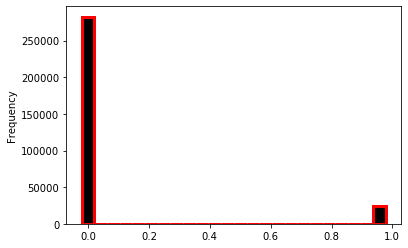

In [449]:
app_train['TARGET'].astype(int).plot.hist( bins=24, align='left', color='black', edgecolor='red', linewidth=3);

In [450]:
del app_test, app_train
gc.collect()


17104

### ------------------------------------------------------------------------

In [451]:
# dataframe den object(kategorik) türü kolonları elde etmek için
def get_categorical_features(df):
    kolonlar = [kolon for kolon in list(df.columns) if df[kolon].dtype == 'object']
    return kolonlar

# categorical özellikleri faktorize etmek için
'''
faktorize işlemi
 A      B      C
0  type1  type1  type1
1  type2  type2  type3
2  type2  type3  type3
-----------------------------
    A  B  C
0   0  0  0
1   1  1  1
2   1  2  1
'''
def factorize_categoricals(df, cats):
    for kolon in cats:
        df[kolon], _ = pd.factorize(df[kolon])
    return df 

# kategorik özelliklerde dummy değişken yapma
def get_dummies(df, cats):
    for kolon in cats:
        df = pd.concat([df, pd.get_dummies(df[kolon], prefix=kolon)], axis=1)
    return df

In [452]:
# df_cats = get_categorical_features(df)
# df = factorize_categoricals(df, df_cats)

##  bureau ve bureau_balance
## bu tablolar yapılan bir kredi başvurusuna ait geçmiş başvuru bilgilerini tutar
## bureau da bir başvurunun geçmişde birçok geçmiş başvurusu olabilir.
## bureau_balance ise herbir geçmiş başvurunun aylık geri ödemesi ile ilgilidir.
## ve yine bu geçmiş başvuruları nasıl kullandığı bilgilerini içerir

In [453]:
bureau = pd.read_csv(Path("data/bureau.csv"))
bureau_balance = pd.read_csv(Path("data/bureau_balance.csv"), nrows = None)



In [454]:
bureau_kategorik = get_categorical_features(bureau)
bureau_balance_kategorik = get_categorical_features(bureau_balance)

bureau = get_dummies(bureau,bureau_kategorik)
bureau_balance = get_dummies(bureau_balance,bureau_balance_kategorik)

In [455]:
# bureau daki geçmiş başvuruların kendi arasında ortalaması alınır
bureau_ort = bureau.groupby('SK_ID_CURR').mean()
bureau_ort['buro_count'] = bureau[['SK_ID_BUREAU','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
bureau_ort.columns = ['b_' + f_ for f_ in bureau_ort.columns]
df = df.merge(right=bureau_ort.reset_index(), how='left', on='SK_ID_CURR')

del bureau_balance, bureau_ort
gc.collect()


0

In [456]:
df.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,...,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_nan,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_nan,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,b_SK_ID_BUREAU,b_DAYS_CREDIT,b_CREDIT_DAY_OVERDUE,b_DAYS_CREDIT_ENDDATE,b_DAYS_ENDDATE_FACT,b_AMT_CREDIT_MAX_OVERDUE,b_CNT_CREDIT_PROLONG,b_AMT_CREDIT_SUM,b_AMT_CREDIT_SUM_DEBT,b_AMT_CREDIT_SUM_LIMIT,b_AMT_CREDIT_SUM_OVERDUE,b_DAYS_CREDIT_UPDATE,b_AMT_ANNUITY,b_CREDIT_ACTIVE_Active,b_CREDIT_ACTIVE_Bad debt,b_CREDIT_ACTIVE_Closed,b_CREDIT_ACTIVE_Sold,b_CREDIT_CURRENCY_currency 1,b_CREDIT_CURRENCY_currency 2,b_CREDIT_CURRENCY_currency 3,b_CREDIT_CURRENCY_currency 4,b_CREDIT_TYPE_Another type of loan,b_CREDIT_TYPE_Car loan,b_CREDIT_TYPE_Cash loan (non-earmarked),b_CREDIT_TYPE_Consumer credit,b_CREDIT_TYPE_Credit card,b_CREDIT_TYPE_Interbank credit,b_CREDIT_TYPE_Loan for business development,b_CREDIT_TYPE_Loan for purchase of shares (margin lending),b_CREDIT_TYPE_Loan for the purchase of equipment,b_CREDIT_TYPE_Loan for working capital replenishment,b_CREDIT_TYPE_Microloan,b_CREDIT_TYPE_Mobile operator loan,b_CREDIT_TYPE_Mortgage,b_CREDIT_TYPE_Real estate loan,b_CREDIT_TYPE_Unknown type of loan,b_buro_count
0,24700.5,406597.5,351000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0247,0.0250,0.0252,0.0369,0.0369,0.0383,0,1.0,1,0.0143,0.0144,0.0144,-9461,-637.0,-2120,-1134.0,-3648.0,2.0,2.0,0.00,0.00,0.0000,0.0690,0.0690,0.0690,0.083037,0.262949,0.139376,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749,6153272.125,-874.00,0.0,-349.0,-697.500000,1681.029,0.0,108131.945625,49156.2,7997.14125,0.0,-499.875,0.0,0.25,0.0,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,35698.5,1293502.5,1129500.0,270000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0959,0.0968,0.0924,0.0529,0.0529,0.0538,0,2.0,0,0.0605,0.0608,0.0497,-16765,-1188.0,-291,-828.0,-1186.0,0.0,0.0,0.08,0.08,0.0806,0.0345,0.0345,0.0345,0.311267,0.622246,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.070862,0.208736,135000.0,0.132217,0.027598,5885878.500,-1400.75,0.0,-544.5,-1097.333333,0.000,0.0,254350.125000,0.0,202500.00000,0.0,-816.000,NaN,0.25,0.0,0.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,6750.0,135000.0,135000.0,67500.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1,NaN,NaN,NaN,-19046,-225.0,-2531,-815.0,-4260.0,

## ----------------------------------------------------------

## previous_application tablosu

In [457]:
prev_application = pd.read_csv(Path("data/previous_application.csv"), nrows = None)


In [458]:
# aykırı değerlere Nan değeri atadık
prev_application['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev_application['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev_application['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev_application['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev_application['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)


In [459]:
prev_application_kategorik = get_categorical_features(prev_application)
prev_application = get_dummies(prev_application, prev_application_kategorik)


In [460]:
## herbir başvuru için geçmiş başvuruların sayısı
prev_apps_count = prev_application[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_application['SK_ID_PREV'] = prev_application['SK_ID_CURR'].map(prev_apps_count['SK_ID_PREV'])

## geçmiş başvurulardaki kategorik olmayan özelliklerin ortalaması
prev_apps_ort = prev_application.groupby('SK_ID_CURR').mean()
prev_apps_ort.columns = ['p_' + col for col in prev_apps_ort.columns]
df = df.merge(right=prev_apps_ort.reset_index(), how='left', on='SK_ID_CURR')

del prev_application, prev_apps_ort
gc.collect()



19

## ---------------------------------------------------------------

## POS_CASH_balance tablosu

In [461]:
pos = pd.read_csv(Path("data/POS_CASH_balance.csv"), nrows = None)



In [462]:
pos_kategorik = get_categorical_features(pos)
pos = get_dummies(pos, pos_kategorik)


In [463]:
### başvurularla ilgili pos ve nakit yapılan kullanımların sayısı
pos_count = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(pos_count['SK_ID_PREV'])

## POS_CASH deki özelliklerin ortalaması
pos_ort = pos.groupby('SK_ID_CURR').mean()
df = df.merge(right=pos_ort.reset_index(), how='left', on='SK_ID_CURR')

del pos, pos_ort
gc.collect()

57

## ----------------------------------------

## installments_payments tablosu

In [464]:
installments_payments = pd.read_csv(Path("data/installments_payments.csv"), nrows = None)


In [465]:
installments_payments_kategorik= get_categorical_features(installments_payments)
installments_payments = get_dummies(installments_payments, installments_payments_kategorik)

In [466]:
# Her kredi taksidi ödemesinde ödediği miktarla aslı arasındaki fark ve bunun yüzdesi
installments_payments['PAYMENT_PERC'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
installments_payments['PAYMENT_DIFF'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']

# vadesi geçmiş günler ve vadesinden önceki günler -- sadece pozitif değerler alınır
installments_payments['DPD'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['DBD'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
installments_payments['DPD'] = installments_payments['DPD'].apply(lambda x: x if x > 0 else 0)
installments_payments['DBD'] = installments_payments['DBD'].apply(lambda x: x if x > 0 else 0)

In [467]:
## geçmiş taksitlerin sayısı
cnt_inst = installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
installments_payments['SK_ID_PREV'] = installments_payments['SK_ID_CURR'].map(cnt_inst['SK_ID_PREV'])

## installments_payments tablosundaki diğer özelliklerin ortalaması
installments_payments_ort = installments_payments.groupby('SK_ID_CURR').mean()
installments_payments_ort.columns = ['i_' + f_ for f_ in installments_payments_ort.columns]
df = df.merge(right=installments_payments_ort.reset_index(), how='left', on='SK_ID_CURR')

del installments_payments, installments_payments_ort
gc.collect()

19

## ----------------------------------------

## credit_card_balance tablosu

In [468]:
credit_card_balance = pd.read_csv(Path("data/credit_card_balance.csv"), nrows = None)

In [469]:
credit_card_balance_kategorik = get_categorical_features(credit_card_balance)
credit_card_balance = get_dummies(credit_card_balance, credit_card_balance_kategorik)


In [470]:
### SK_ID_CURR ile verilen geçmiş başvurların sayısı
nb_prevs = credit_card_balance[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
credit_card_balance['SK_ID_PREV'] = credit_card_balance['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

### diğer kolonların ortalaması 
credit_card_balance_ort = credit_card_balance.groupby('SK_ID_CURR').mean()
credit_card_balance_ort.columns = ['cc_bal_' + f_ for f_ in credit_card_balance_ort.columns]
df = df.merge(right=credit_card_balance_ort.reset_index(), how='left', on='SK_ID_CURR')

### ********* ###
df.to_csv('birlestirilmis_data.csv', index= False)
### ********* ###

del credit_card_balance, credit_card_balance_ort
gc.collect()

0

# -<-<-<-<-<-<-<-<-<--<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-